# Validation Notebook

In this notebook, you will find graphs representing results from simulations previously run, so you can compare your results with these

## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from leap.simulation import Simulation
from leap.logger import get_logger
from leap.utils import get_data_path

## Run Simulation

<span style="color:yellow">Currently, the simulations take much to long to run, so calling simulation.run() in the Jupyter notebook and using the generated outcome_matrix object for analysis is infeasible. Instead, run it seperately and use the outputted csvs!</span>

To run the simulation, open a terminal:

```sh
leap --run-simulation --time-horizon <TIME_HORIZON> --num-births-initial <N_BIRTHS> --min-year <STARTING_YEAR> --province <PROVINCE>
    --path-output <PATH/TO/SAVE/OUTPUT/> --ignore-pollution
```

In [43]:
# set output path to output/jupter folder in root
RUN_BUNDLE_NAME = "2001-30-CA-M3-100-110"  # REPLACE WITH YOUR DESIRED SIMULATION RUN
PATH_OUTPUT = "PATH/TO/OUTPUT"  # Replace with the path to the output folder
PATH_OUTPUT = "/Users/work/Coding/RESP/leap/output/tmp/"
PROVINCE = "CA"
STARTING_YEAR = 2024
PROJECTION_SCENARIO = "LG"
N_BIRTHS = 10

## Figure 5. Population Comparison

Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

**NOTE**: default simulation folder naming scheme:

`~/leap/output/INITIAL_YEAR-TIME_HORIZON-PROVINCE-GROWTH_TYPE-INITIAL_POPULATION-MAX_AGE/`

### Load Population Data

In [18]:
# StatCan Population Data
canada_pop_df = pd.read_csv(get_data_path("processed_data/birth/initial_pop_distribution_prop.csv"))

In [19]:
# Simulation Population Data
simulation_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, "outcome_matrix_alive.csv"))

In [20]:
# Filter to only include chosen province, and  dates after chosen baseline year
canada_pop_df = canada_pop_df[
    (canada_pop_df['province'] == PROVINCE) &
    (canada_pop_df['year'] >= STARTING_YEAR)
]

In [21]:
# Filter to only include dates after chosen starting year
simulation_df = simulation_df[simulation_df["year"] >= STARTING_YEAR]

### Plots

In [30]:
# Figure Parameters
figure_years = range(2024, 2027)
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

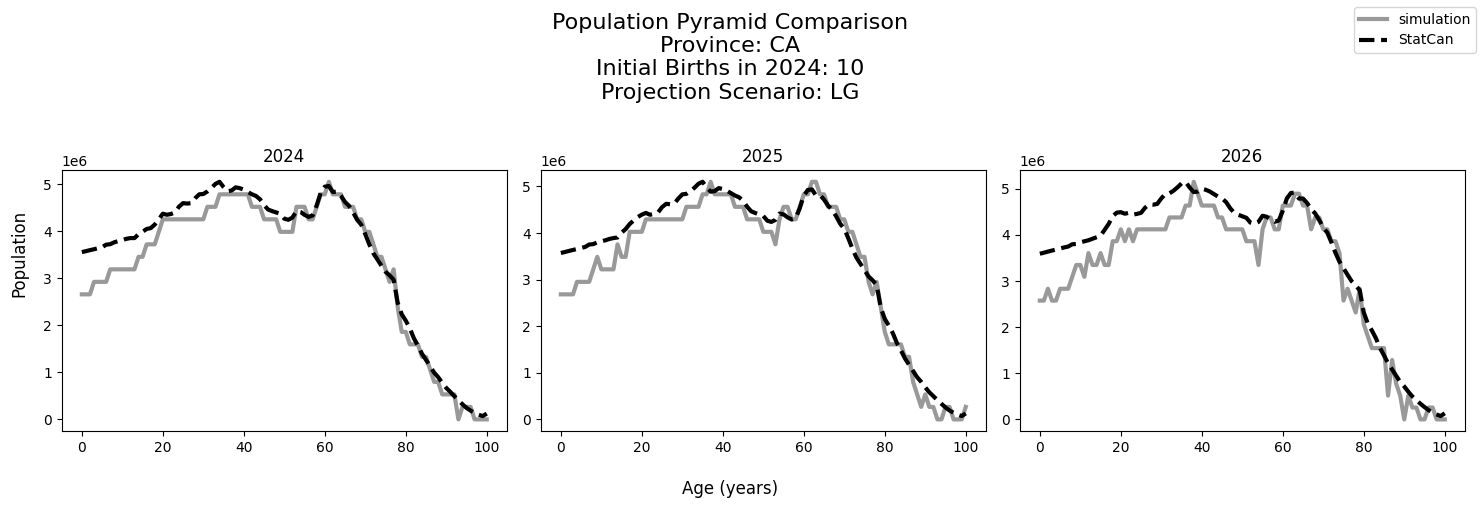

In [44]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    # Get axis for current plot by indexing with i
    if num_rows == 1:
        if num_cols == 1:
            ax: plt.Axes = axs
        else:
            ax: plt.Axes = axs[i % num_cols]
    else:
        ax: plt.Axes = axs[i // num_rows][i % num_cols]

    # Filter stats data by current year
    canada_pop_filtered_df = canada_pop_df[canada_pop_df["year"] == year]
    # Group stats data by age and sum over sexes to current number of population for each age
    canada_pop_totaled_df = canada_pop_filtered_df.groupby("age").sum().reset_index()

    # Filter simulation data by current year
    simulation_pop_filtered_df = simulation_df[
        (simulation_df["year"] == year) &
        (simulation_df["age"] <= 100)
    ]
    # Group by age and sum over sexes to current number of population for each age
    simulation_pop_totaled_df = simulation_pop_filtered_df.groupby("age").sum().reset_index()
    # Scale the simulation data to match the maximum population of the stats data
    max_stats_age = canada_pop_totaled_df["n_age"].max()
    max_simulation_age = simulation_pop_totaled_df["n_alive"].max()
    scaling_factor = max_stats_age / max_simulation_age
    simulation_pop_totaled_df["n_alive"] *= scaling_factor

    # Plot simulation data
    ax.plot(simulation_pop_totaled_df["age"], simulation_pop_totaled_df["n_alive"],
            color="#999999", linestyle="-", linewidth=3, label="simulated")
    # Plot historical and projected data from Stats Canada
    ax.plot(canada_pop_totaled_df["age"], canada_pop_totaled_df["n_age"],
            color="black", linestyle="dashed", linewidth=3, label="observed")

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# Additional labels
fig.supxlabel("Age (years)")
fig.supylabel("Population")
fig.suptitle(
    f"Population Pyramid Comparison\n"+
    f"Province: {PROVINCE}\n"+
    f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"+
    f"Projection Scenario: {PROJECTION_SCENARIO}", 
    fontsize=16
)
fig.legend(["simulation", "StatCan"])
plt.tight_layout(rect=[0.01, 0, 1, 0.95])
plt.show()

## Figure 6. Rate of Antibiotic Prescriptions by Sex

Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted),
with the floor rate of 50 per 1000 (purple).

### Load Data

In [39]:
# Load antibiotic data from StatsCanada
canada_infant_abx_df = pd.read_csv(get_data_path("processed_data/InfantAbxBC.csv"))

### Plots

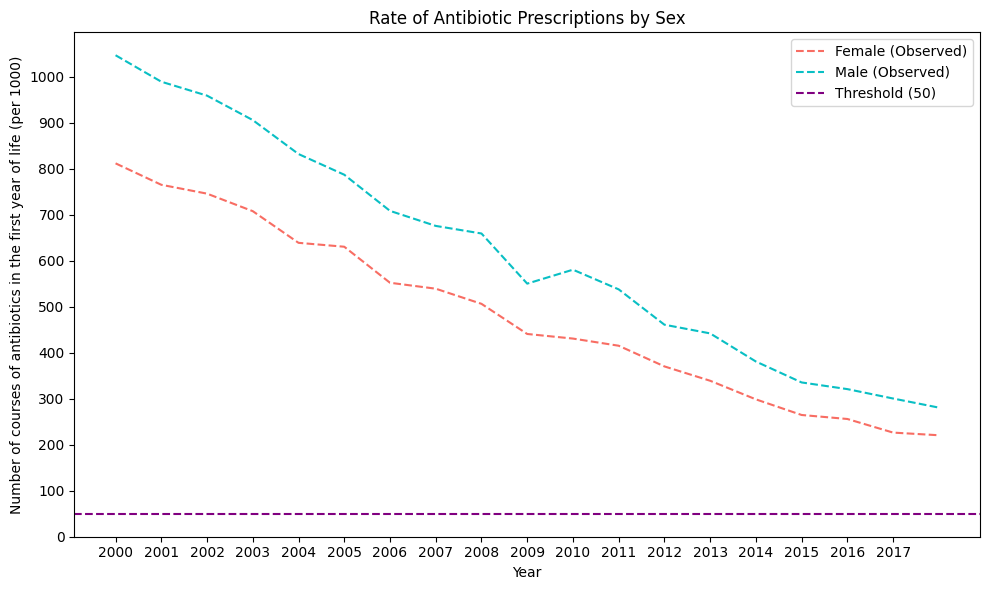

In [45]:
plt.figure(figsize=(10, 6))

# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}

# Dotted lines from count_data
for sex in canada_infant_abx_df['sex'].unique():
    canada_infant_abx_filtered = canada_infant_abx_df[canada_infant_abx_df['sex'] == sex]
    plt.plot(
        canada_infant_abx_filtered['year'],
        canada_infant_abx_filtered['rate'],
        c=sex_colour_dict[sex],
        linestyle='dashed',
        label=f"{sex} (Observed)"
    )

# Additional elements
plt.axhline(y=50, color='purple', linestyle='dashed', label="Threshold (50)")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1000)")
plt.xlabel("Year")
plt.xticks(range(canada_infant_abx_df['year'].min(), canada_infant_abx_df['year'].max()))
plt.yticks(range(0, 1100, 100))
plt.legend(title="")
plt.title("Rate of Antibiotic Prescriptions by Sex")

# Save the figure
plt.tight_layout()
plt.show()

In [ ]:
# Read in antibiotic data from simulation
simulation_infant_abx_df = pd.read_csv(
    pathlib.Path(PATH_OUTPUT, "outcome_matrix_antibiotic_exposure.csv")
)
simulation_infant_abx_df['sex'] = simulation_infant_abx_df['sex'].map(
    lambda x: "Female" if x == "F" else "Male"
)
simulation_infant_abx_totaled_df = simulation_infant_abx_df.groupby(["year", "sex"]).sum().reset_index()

# Filter data for age 0
simulation_age0_abx_df = simulation_infant_abx_df.query("age == 0")

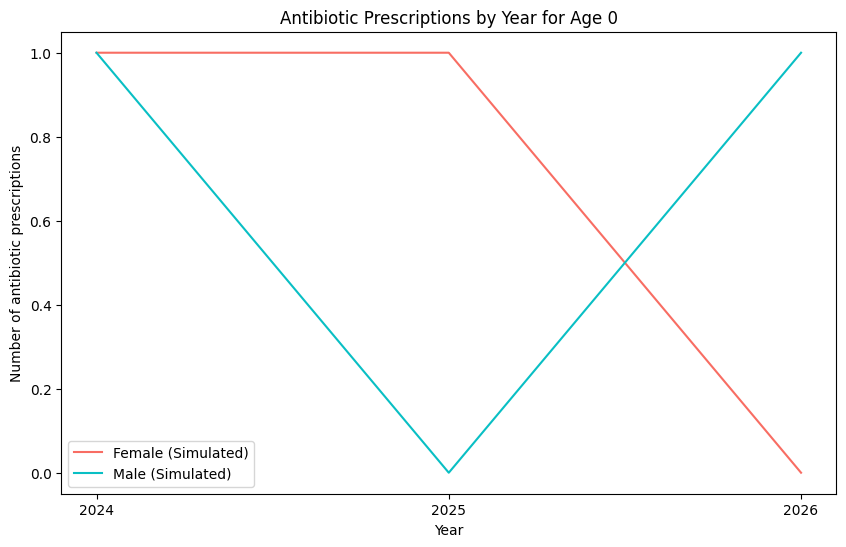

In [46]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot for Female
simulation_age0_abx_F_df = simulation_age0_abx_df.query("sex == 'Female'")
plt.plot(
    simulation_age0_abx_F_df['year'],
    simulation_age0_abx_F_df['n_antibiotic_exposure'],
    label='Female (Simulated)',
    color=sex_colour_dict['Female'],
    linestyle='solid'
)

# Plot for Male
simulation_age0_abx_M_df = simulation_age0_abx_df.query("sex == 'Male'")
plt.plot(
    simulation_age0_abx_M_df['year'],
    simulation_age0_abx_M_df['n_antibiotic_exposure'],
    label='Male (Simulated)',
    color=sex_colour_dict['Male'],
    linestyle='solid'
)

# Additional elements
plt.xlabel("Year")
plt.ylabel("Number of antibiotic prescriptions")
plt.xticks(figure_years)
plt.title("Antibiotic Prescriptions by Year for Age 0")
plt.legend()
plt.show()

## Figure 7. Asthma Prevalence Rates

Asthma prevalence rates per 1000 general population by sex (left: females; right: males) from the model (grey solid) and estimated or projected (black dashed).

### Load Data

In [48]:
# Read and process obsereved stats asthma prevalence data
asthma_prev = pd.read_csv(get_data_path("processed_data/master_asthma_prev_inc.csv"))
asthma_prev = asthma_prev[asthma_prev["age"] <= 60]
asthma_prev['sex'] = asthma_prev['sex'].map(lambda s: "F" if s == 0 else "M")

# Read simulation asthma prevalence data
simualtion_prev_df = pd.read_csv(
    pathlib.Path(PATH_OUTPUT, "outcome_matrix_asthma_prevalence.csv")
)

### Plots

In [49]:
# Figure Parameters
figure_years = range(2024, 2027)
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

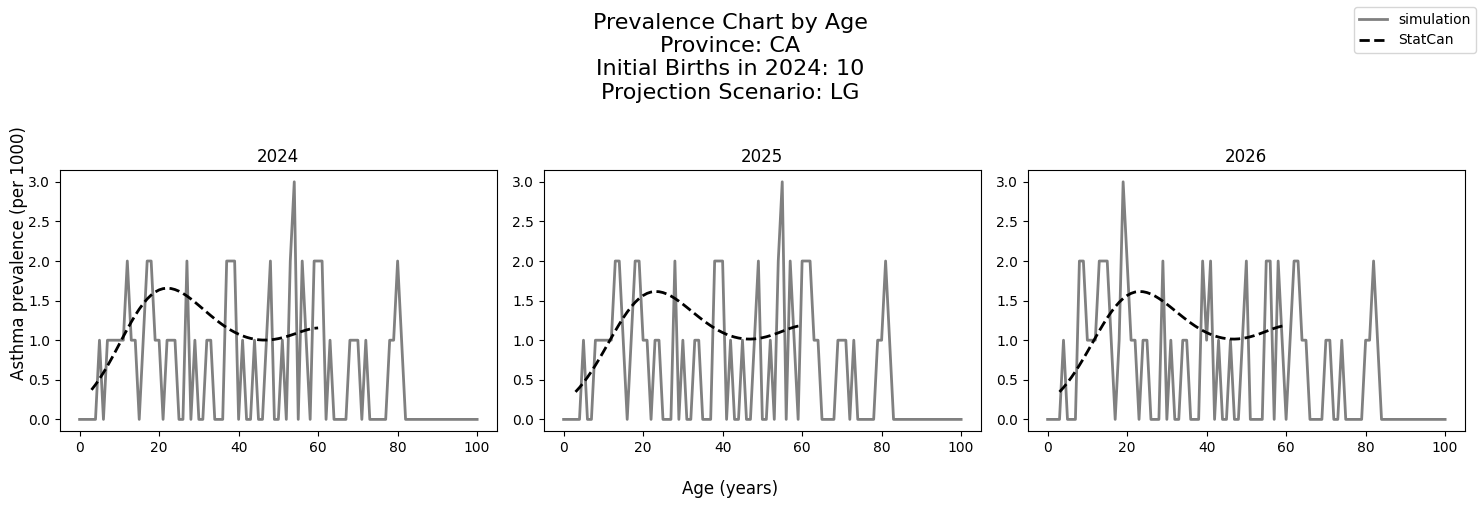

In [53]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

for i, year in enumerate(figure_years):
    if num_rows == 1:
        if num_cols == 1:
            ax: plt.Axes = axs
        else:
            ax: plt.Axes = axs[i % num_cols]
    else:
        ax: plt.Axes = axs[i // num_rows][i % num_cols]

    # Filter stats data by current year
    canada_pop_filtered_df = (
        asthma_prev.query("year == @year and sex == 'M'")
        .groupby("age").sum().reset_index()
    )
    canada_pop_filtered_df["prev"] *= 100
    
    simualtion_prev_filtered_df = (
        simualtion_prev_df.query("year == @year and sex == 'M'")
        .groupby("age").sum().reset_index()
    )

    ax.plot(simualtion_prev_filtered_df["age"], simualtion_prev_filtered_df["n_asthma"],
            color="grey", linestyle="solid", linewidth=2)
    ax.plot(canada_pop_filtered_df["age"], canada_pop_filtered_df["prev"],
            color="black", linestyle="dashed", linewidth=2)
    

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)

fig.supxlabel("Age (years)")
fig.supylabel("Asthma prevalence (per 1000)")
fig.suptitle(
    f"Prevalence Chart by Age\n"+
    f"Province: {PROVINCE}\n"+
    f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"+
    f"Projection Scenario: {PROJECTION_SCENARIO}", 
    fontsize=16
)
fig.legend(["simulation", "StatCan"])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()